In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()
        
        
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

### ROZWIĄZANIE

In [2]:
import random
def randPoints(num,rang):
    random.seed()
    points=[]
    for i in range(0,num):
        points.append((random.uniform(-rang,rang),random.uniform(-rang,rang)))
    return points

points=randPoints(20,10)

In [3]:
import time
import copy
import math

def det(point1,point2,point3,which):
        if which==0:
            return (point1[0]*point2[1]+point1[1]*point3[0]+point2[0]*point3[1]-point3[0]*point2[1]-point3[1]*point1[0]-point2[0]*point1[1])
        else:
            return ((point1[0]-point3[0])*(point2[1]-point3[1])-(point2[0]-point3[0])*(point1[1]-point3[1]))
        
def findStart(points):
    min=points[0]
    for i in points:
        if i[1]<min[1]:
            min=i
        elif i[1]==min[1]:
            if i[0]<min[0]:
                min=i         
    points.remove(min)
    return min

def powDistance(a,b):
    return (a[0]-b[0])**2+(a[1]-b[1])**2

def jarvis(points,precision,filename=0):
    startTime=time.time()
    print("jarvis loaded ",len(points)," points")
    start=findStart(points)
    points.append(start)
    oto=[start]
    x=(start[0]+1,start[1]+1)
    while x[0]!=start[0] or x[1]!=start[1]:
        x=points[0]
        if oto[-1]==x:
            x=points[1]
        for i in range(len(points)):
            d=det(oto[-1],x,points[i],0)
            if d<-precision:
                 x=points[i]
            elif d<precision:
                if powDistance(oto[-1],x)<powDistance(oto[-1],points[i]):
                    x=points[i]
                
        oto.append(x)

    oto.pop()
    print("execution time",time.time()-startTime,"sec\nconvex hull contains",len(oto),"points")
    
    if filename!=0:
        file=open(filename,"w")
        for i in oto:
            file.write(str(i[0])+" "+str(i[1])+"\n")
        file.close()
        
    return oto
def splitConvexHullByX(hull):#O(k)
    u=[]
    l=[]
    min=0
    max=0
    for i in range(len(hull)):
        if hull[i][0]<hull[min][0]:
            min=i
        if hull[i][0]>hull[max][0]:
            max=i
    i=min
    j=min
    while i!=max or j!=max:
        if i!=max:
            u.append(hull[i])
            i=i-1
            if i<0:
                i=len(hull)-1
        if j!=max:
            l.append(hull[j])
            j=j+1
            if j>len(hull)-1:
                j=0
                
    u.append(hull[i])
    l.append(hull[j])
    return (u,l)


def getAntiPodal(u,l):
    podal=[]
    i=0
    j=len(l)-1
    while i<len(u)-1 or j>0:
        podal.append((u[i],l[j]))
        
        if i==len(u)-1:
            j=j-1
        elif j==0:
            i=i+1
        elif (u[i+1][1]-u[i][1])*(l[j][0]-l[j-1][0])>(u[i+1][0]-u[i][0])*(l[j][1]-l[j-1][1]):
            i=i+1
        else:
            j=j-1
    return podal
    
def getMiddlePoint(point1,point2):
    vec=(point2[0]-point1[0],point2[1]-point1[1])
    return(point1[0]+vec[0]/2,point1[1]+vec[1]/2)
def getCircleFromPoints(point1,point2,point3):
    x=((point1[0]**2+point1[1]**2)*(point2[1]-point3[1])+(point2[0]**2+point2[1]**2)*(point3[1]-point1[1])+(point3[0]**2+point3[1]**2)*(point1[1]-point2[1]))/(2*(point1[0]*(point2[1]-point3[1])-point1[1]*(point2[0]-point3[0])+point2[0]*point3[1]-point3[0]*point2[1]))
    y=((point1[0]**2+point1[1]**2)*(point3[0]-point2[0])+(point2[0]**2+point2[1]**2)*(point1[0]-point3[0])+(point3[0]**2+point3[1]**2)*(point2[0]-point1[0]))/(2*(point1[0]*(point2[1]-point3[1])-point1[1]*(point2[0]-point3[0])+point2[0]*point3[1]-point3[0]*point2[1]))
    r=math.sqrt((x-point1[0])**2+(y-point1[1])**2)
    return((x,y),r)

def isEnclosing(oto,middle,radius):
    for i in oto:
        if math.sqrt(powDistance(middle,i))>radius+10**-1:
            return False
    return True
def calculateMinimalCircle(podal,oto):
    allPoints=[]
    max=0
    maxPair=((0,0),(0,0))
    for i in podal:
        if powDistance(i[0],i[1])>max:
            max=powDistance(i[0],i[1])
            maxPair=i
            
    middle=getMiddlePoint(maxPair[0],maxPair[1])
    allPoints=allPoints+getCircle(middle,math.sqrt(max)/2,10000)
    if isEnclosing(oto,middle,math.sqrt(max)/2)==True:
        return ((middle,math.sqrt(max)/2),allPoints)
    
    left=((0,0),0,-1000,0)
    right=((0,0),0,-1000,0)
            
    for i in oto:
        if det(maxPair[0],maxPair[1],i,0)<10**-11 and det(maxPair[0],maxPair[1],i,0)>-10**-11:
            continue

        currentCircle=getCircleFromPoints(maxPair[0],maxPair[1],i)
        allPoints=allPoints+getCircle(currentCircle[0],currentCircle[1],10000)
        
        if maxPair[1][1]<maxPair[0][1]:
            maxPair=maxPair[::-1]
              
        if det(maxPair[0],maxPair[1],i,0)>0:
            if det(maxPair[0],maxPair[1],currentCircle[0],0)>0 and powDistance(currentCircle[0],middle)>left[2]:
                left=(currentCircle[0],currentCircle[1],powDistance(currentCircle[0],middle),i)
                
  
            elif -powDistance(currentCircle[0],middle)>left[2]:
                left=(currentCircle[0],currentCircle[1],-powDistance(currentCircle[0],middle),i)
                
                
        else:       
            if det(maxPair[0],maxPair[1],currentCircle[0],0)<0 and powDistance(currentCircle[0],middle)>right[2]:
                right=(currentCircle[0],currentCircle[1],powDistance(currentCircle[0],middle),i)
                
                
            elif powDistance(currentCircle[0],middle)>right[2]:
                right=(currentCircle[0],currentCircle[1],-powDistance(currentCircle[0],middle),i)
                
                
      
    isel=isEnclosing(oto,left[0],left[1])
    iser=isEnclosing(oto,right[0],right[1])
    if isel==True and iser==True:
        if left[1]<right[1]:
            return (left,allPoints)
        else:
            return (right,allPoints)
    elif isel==True:
        return (left,allPoints)
    elif iser==True:
        return (right,allPoints)
    else:
        return (getCircleFromPoints(left[3],right[3],maxPair[0]),allPoints)

    #return(left,right,(middle,math.sqrt(max)/2))
def getCircle(point,radius,num):
    random.seed()
    points=[]
    for i in range(0,num):
        r=math.radians(random.uniform(-180,180))
        points.append((point[0]+radius*math.cos(r),point[1]+radius*math.sin(r)))
    return points
def vecLength(vec):
    return abs(math.sqrt(vec[0]**2+vec[1]**2))
def getPerpVec(vec):
    return [vec[1],-vec[0]]
class supportLine:
    vec=[0,0]
    point=0
    def __init__(self,vec,point):
        self.vec=vec
        self.point=point
def getMinAngle(vec1,vec2):
    min=-1
    i=0
    idx=0
    while i<len(vec1):
        if (vec1[i].vec[0]*vec2[i][0]+vec1[i].vec[1]*vec2[i][1])/(vecLength(vec2[i])*vecLength(vec1[i].vec))>min:
            min=(vec1[i].vec[0]*vec2[i][0]+vec1[i].vec[1]*vec2[i][1])/(vecLength(vec2[i])*vecLength(vec1[i].vec))
            idx=i
        i+=1
    return idx+1
        
    
def calculateBoundingBox(oto):
    rectangles=[]
    minY=0
    maxY=0
    minX=0
    maxX=0
    
    for i in range(len(oto)):
        if oto[i][1]>oto[maxY][1]:
            maxY=i
        if oto[i][1]<oto[minY][1]:
            minY=i
        if oto[i][0]>oto[maxX][0]:
            maxX=i
        if oto[i][0]<oto[minX][0]:
            minX=i
            
        support1=supportLine([0,1],minX)
        support2=supportLine([0,-1],maxX)
        
        support3=supportLine([-1,0],minY)
        support4=supportLine([1,0],maxY)
      

    counter=0
    area=math.inf
    per=math.inf
    minPerRect=((0,0),(0,0),(0,0),(0,0))
    minRect=((0,0),(0,0),(0,0),(0,0))
    otoNum=len(oto)
    while counter!=len(oto):
        vec1=[oto[(support1.point+1)%otoNum][0]-oto[support1.point][0],oto[(support1.point+1)%otoNum][1]-oto[support1.point][1]]
        vec2=[oto[(support2.point+1)%otoNum][0]-oto[support2.point][0],oto[(support2.point+1)%otoNum][1]-oto[support2.point][1]]
        vec3=[oto[(support3.point+1)%otoNum][0]-oto[support3.point][0],oto[(support3.point+1)%otoNum][1]-oto[support3.point][1]]
        vec4=[oto[(support4.point+1)%otoNum][0]-oto[support4.point][0],oto[(support4.point+1)%otoNum][1]-oto[support4.point][1]]
        
        minAngle=getMinAngle([support1,support2,support3,support4],[vec1,vec2,vec3,vec4])
     
        if minAngle==1:
            support1.vec=vec1
            support1.point=(support1.point+1)%otoNum
            support2.vec=[-vec1[0],-vec1[1]]
            support3.vec=[-vec1[1],vec1[0]]
            support4.vec=[vec1[1],-vec1[0]]
        elif minAngle==2:
            support2.vec=vec2
            support2.point=(support2.point+1)%otoNum
            support1.vec=[-vec2[0],-vec2[1]]
            support3.vec=[vec2[1],-vec2[0]]
            support4.vec=[-vec2[1],vec2[0]]
        elif minAngle==3:
            support3.vec=vec3
            support3.point=(support3.point+1)%otoNum
            support4.vec=[-vec3[0],-vec3[1]]
            support1.vec=[vec3[1],-vec3[0]]
            support2.vec=[-vec3[1],vec3[0]]
        else:
            support4.vec=vec4
            support4.point=(support4.point+1)%otoNum
            support3.vec=[-vec4[0],-vec4[1]]
            support2.vec=[vec4[1],-vec4[0]]
            support1.vec=[-vec4[1],vec4[0]]
                   
        temp=(oto[support1.point][0]+support1.vec[0],oto[support1.point][1]+support1.vec[1])
        a1=(temp[1]-oto[support1.point][1])/(temp[0]-oto[support1.point][0])
        b1=oto[support1.point][1]-a1*oto[support1.point][0]
        b2=oto[support2.point][1]-a1*oto[support2.point][0]
        b3=oto[support3.point][1]-(-1/a1)*oto[support3.point][0]
        b4=oto[support4.point][1]-(-1/a1)*oto[support4.point][0]
        
 
        x1=(b3-b1)/(a1-(-1/a1))
        y1=a1*x1+b1 
        x2=(b4-b1)/(a1-(-1/a1))
        y2=a1*x2+b1
        x3=(b3-b2)/(a1-(-1/a1))
        y3=a1*x3+b2 
        x4=(b4-b2)/(a1-(-1/a1))
        y4=a1*x4+b2
        
        rectangles.append(LinesCollection([[(x1,y1),(x2,y2)],[(x3,y3),(x4,y4)],[(x1,y1),(x3,y3)],[(x2,y2),(x4,y4)]]))
        
        if math.sqrt(powDistance((x1,y1),(x2,y2))*powDistance((x1,y1),(x3,y3)))<area:
            area=math.sqrt(powDistance((x1,y1),(x2,y2))*powDistance((x1,y1),(x3,y3)))
            minRect=((x1,y1),(x2,y2),(x3,y3),(x4,y4))
        if 2*math.sqrt(powDistance((x1,y1),(x2,y2)))+2*math.sqrt(powDistance((x1,y1),(x3,y3)))<per:
            per=2*math.sqrt(powDistance((x1,y1),(x2,y2)))+2*math.sqrt(powDistance((x1,y1),(x3,y3)))
            minPerRect=((x1,y1),(x2,y2),(x3,y3),(x4,y4))
                
        counter+=1
    return ((minRect,minPerRect),rectangles)
def plotLine(a,b,x1,x2):
    y1=a*x1+b
    y2=a*x2+b
    return ((x1,y1),(x2,y2))          

### DALSZA CZĘŚĆ ZAWIERA JEDYNIE WIZUALIZACJĘ DZIAŁANIA ALGORYTMU

jarvis loaded  20  points
execution time 0.0009999275207519531 sec
convex hull contains 7 points


<IPython.core.display.Javascript object>


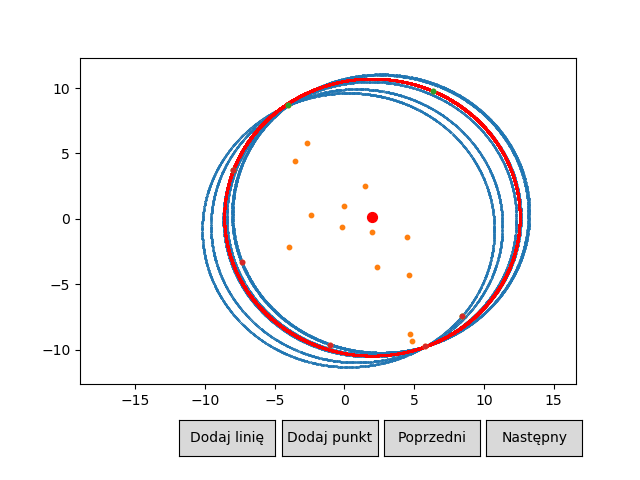

In [4]:
oto=jarvis(points,10**-11)
#(u,l)=splitConvexHull(oto)
(u,l)=splitConvexHullByX(oto)
podal=getAntiPodal(u,l)  
#print(podal)
#print(podal2)
mid=calculateMinimalCircle(podal,oto)
#circleLeft=getCircle(left[0],left[1],10000)
#circleRight=getCircle(right[0],right[1],10000)
circleMid=getCircle(mid[0][0],mid[0][1],10000)
oto.reverse()
recPoints=calculateBoundingBox(oto)


%matplotlib notebook
#scenes=[Scene([PointsCollection([mid[0]],s=100,c='red'),PointsCollection(circleMid,s=1,c='red'),PointsCollection(points,s=10),PointsCollection(u,s=10),PointsCollection(l,s=10)],[LinesCollection([line1,line2,line3,line4])])]
scenes=[Scene([PointsCollection(mid[1],s=0.01),PointsCollection([mid[0][0]],s=50,c='red'),PointsCollection(circleMid,s=1,c='red'),PointsCollection(points,s=10),PointsCollection(u,s=10),PointsCollection(l,s=10)],[])]
              #[LinesCollection([[recPoints[0][0],recPoints[0][1]],[recPoints[0][2],recPoints[0][3]],[recPoints[0][0],recPoints[0][2]],[recPoints[0][1],recPoints[0][3]],[recPoints[1][0],recPoints[1][1]],[recPoints[1][2],recPoints[1][3]],[recPoints[1][0],recPoints[1][2]],[recPoints[1][1],recPoints[1][3]]])])]

plot = Plot(scenes)
plot.draw()  

<IPython.core.display.Javascript object>


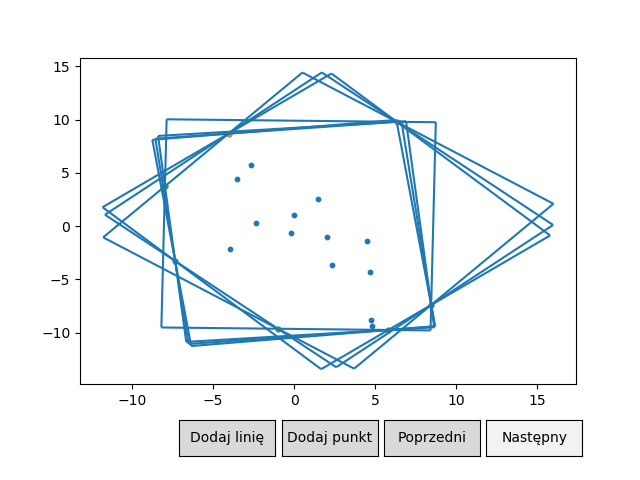

In [5]:
%matplotlib notebook
scenes2=[]
rem=[]
for i in range(len(recPoints[1])):
    rem.append(recPoints[1][i])
    scenes2.append(Scene([PointsCollection(points,s=10),PointsCollection(u,s=10),PointsCollection(l,s=10)],copy.deepcopy(rem)))

rem.append(LinesCollection([[recPoints[0][0][0],recPoints[0][0][1]],[recPoints[0][0][2],recPoints[0][0][3]],[recPoints[0][0][0],recPoints[0][0][2]],[recPoints[0][0][1],recPoints[0][0][3]],[recPoints[0][1][0],recPoints[0][1][1]],[recPoints[0][1][2],recPoints[0][1][3]],[recPoints[0][1][0],recPoints[0][1][2]],[recPoints[0][1][1],recPoints[0][1][3]]],color='red')) 
scenes2.append(Scene([PointsCollection(points,s=10),PointsCollection(u,s=10),PointsCollection(l,s=10)],copy.deepcopy(rem)))

#scenes=[Scene([PointsCollection(points,s=10),PointsCollection(u,s=10),PointsCollection(l,s=10)],recPoints[1])]
              #[LinesCollection([[recPoints[0][0][0],recPoints[0][0][1]],[recPoints[0][0][2],recPoints[0][0][3]],[recPoints[0][0][0],recPoints[0][0][2]],[recPoints[0][0][1],recPoints[0][0][3]],[recPoints[0][1][0],recPoints[0][1][1]],[recPoints[0][1][2],recPoints[0][1][3]],[recPoints[0][1][0],recPoints[0][1][2]],[recPoints[0][1][1],recPoints[0][1][3]]])])]

plot = Plot(scenes2)
plot.draw()